In [1]:
# notebook adapted from https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/brain3k/1-Processing-and-Integration.html

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import sys
import os
from pathlib import Path
import muon as mu
import mudatasets
import seaborn as sns

/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sgpeo/opt/miniconda3/envs/celleni

In [3]:
# import requires setting a PYTHONPATH with the data_import directory
import h5ad_preparation as prep

20230908-151137.470 98872 INFO root:26 local study files stored in: /Users/sgpeo/projects/celleniumnew/cellenium/scratch


In [5]:
mdata = mudatasets.load("brain3k_multiome", data_dir=prep.basedir, full=True)

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at /Users/sgpeo/projects/celleniumnew/cellenium/

/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5


/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/sgpeo/projects/celleniumnew/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz


In [6]:
mdata.var_names_make_unique()

# RNA

In [7]:
rna = mdata['rna']

In [8]:
prep.make_sparse(rna)

In [9]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
# filter
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 2)

In [11]:
# normalize
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

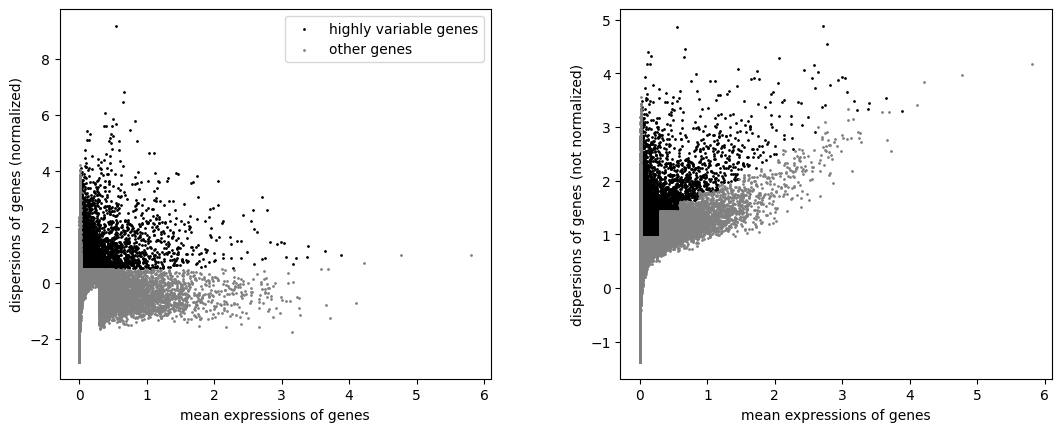

In [12]:
# Prepare umap
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [13]:
#subset down to 10 % of the samples
rna.obs['take'] = pd.np.random.uniform(size=rna.obs.shape[0]) <= 0.1
mu.pp.filter_obs(rna, 'take')
#subset down to 1 % of the genes
rna.var['take'] = pd.np.random.uniform(size=rna.var.shape[0]) <= 0.01
mu.pp.filter_var(rna, 'take')

/var/folders/0c/8txmxvc97x5c0qhb62j88r000000gq/T/ipykernel_98872/1469532489.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  rna.obs['take'] = pd.np.random.uniform(size=rna.obs.shape[0]) <= 0.1
/var/folders/0c/8txmxvc97x5c0qhb62j88r000000gq/T/ipykernel_98872/1469532489.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  rna.var['take'] = pd.np.random.uniform(size=rna.var.shape[0]) <= 0.01


In [14]:
# save the lognorm
rna.layers["lognorm"] = rna.X.copy()

In [15]:
sc.pp.scale(rna, max_value=10)

In [16]:
sc.tl.pca(rna, svd_solver='arpack')

In [17]:
# clustering
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


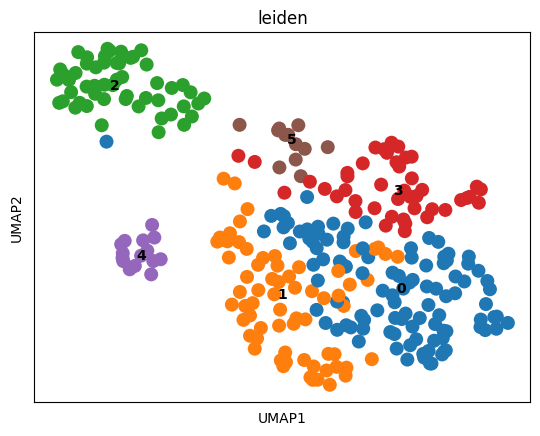

In [18]:
# umap
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [19]:
rna.obs['celltype_by_rna'] = rna.obs['leiden']

In [20]:
rna.X = rna.layers['lognorm']

In [21]:
prep.calculate_differentially_expressed_genes(rna, ['celltype_by_rna'])

diff.exp. genes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]
20230908-151154.352 98872 INFO root:387 calculate_differentially_expressed_genes: found a list of genes for these attributes: ['celltype_by_rna']


,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,PPP2R2B,6.629251,1.135689,3.373952e-11,1.234866e-08,0,_OTHERS_,celltype_by_rna
1,MAP4K4,6.187111,1.126810,6.127667e-10,1.121363e-07,0,_OTHERS_,celltype_by_rna
2,USP54,5.468192,1.274787,4.546506e-08,4.160053e-06,0,_OTHERS_,celltype_by_rna
3,CCP110,4.748562,1.265468,2.048682e-06,1.249696e-04,0,_OTHERS_,celltype_by_rna
4,TMEM98,3.757119,1.408166,1.718804e-04,6.290824e-03,0,_OTHERS_,celltype_by_rna
...,...,...,...,...,...,...,...,...
168,CACNG2,0.416628,0.927313,6.769509e-01,1.000000e+00,5,_OTHERS_,celltype_by_rna
169,KCNIP4-IT1,0.361536,1.033639,7.176986e-01,1.000000e+00,5,_OTHERS_,celltype_by_rna
170,KRTCAP2,0.323661,0.690321,7.461947e-01,1.000000e+00,5,_OTHERS_,celltype_by_rna
171,TUBGCP4,0.292672,0.553984,7.697727e-01,1.000000e+00,5,_OTHERS_,celltype_by_rna


In [22]:
prep.remove_raw_and_layers(rna)

# ATAC

In [23]:
from muon import atac as ac

In [24]:
atac = mdata.mod['atac']

In [25]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [26]:
# filter
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))

In [27]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 464.14it/s]


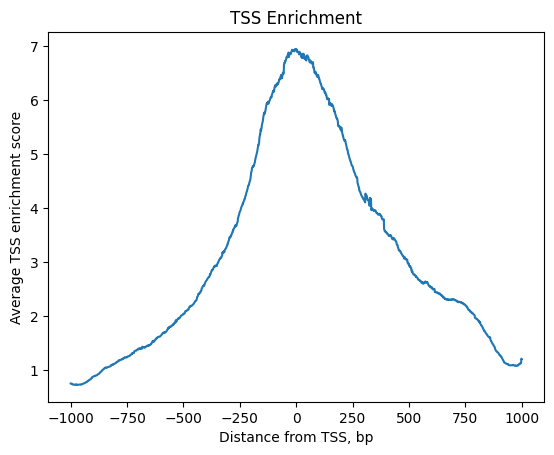

In [28]:
ac.pl.tss_enrichment(tss)

In [29]:
# normalisation
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers['lognorm'] = atac.X

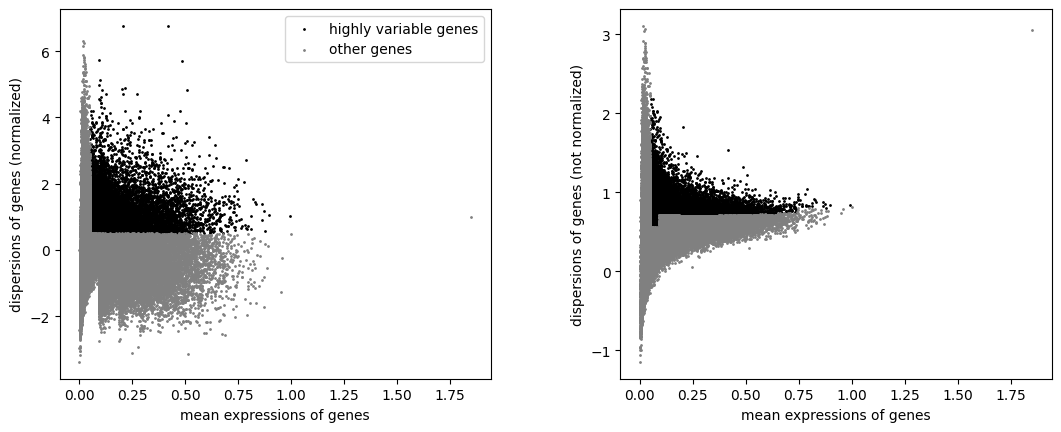

In [30]:
# variable regions
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [31]:
#subset down to 10 % of the samples
atac.obs['take'] = pd.np.random.uniform(size=atac.obs.shape[0]) <= 0.1
mu.pp.filter_obs(atac, 'take')
#subset down to 1 % of the genes
atac.var['take'] = pd.np.random.uniform(size=atac.var.shape[0]) <= 0.01
mu.pp.filter_var(atac, 'take')

/var/folders/0c/8txmxvc97x5c0qhb62j88r000000gq/T/ipykernel_98872/481395927.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  atac.obs['take'] = pd.np.random.uniform(size=atac.obs.shape[0]) <= 0.1
/var/folders/0c/8txmxvc97x5c0qhb62j88r000000gq/T/ipykernel_98872/481395927.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  atac.var['take'] = pd.np.random.uniform(size=atac.var.shape[0]) <= 0.01


In [32]:
# prepare umap
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac, svd_solver='arpack')

In [33]:
# clustering
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.5)

In [34]:
# umap
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


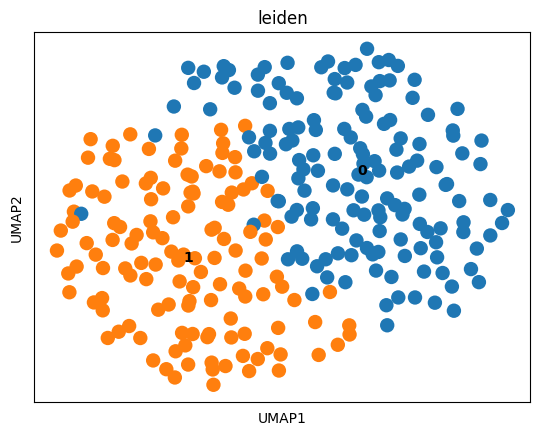

In [35]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

In [36]:
# assign new names
atac.obs['celltype_by_atac'] = atac.obs['leiden']
atac.obs['celltype_by_atac'] = atac.obs['celltype_by_atac'].astype("category")

In [37]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs['celltype_by_atac'].cat.categories)))

atac.uns["celltype_colors"] = list(map(to_hex, colors))

/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


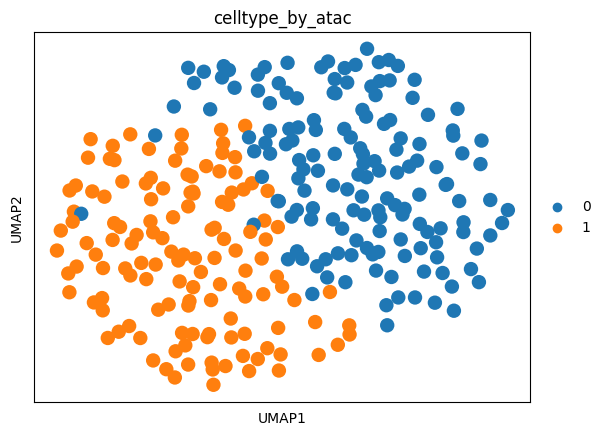

In [38]:
sc.pl.umap(atac, color="celltype_by_atac")

In [39]:
prep.remove_raw_and_layers(atac)

In [40]:
mdata.update()

In [41]:
atac.uns['files'] = dict(atac.uns['files'])
atac.uns['atac'] = dict(atac.uns['atac'])

In [42]:
prep.calculate_differential_peaks(atac, ['celltype_by_atac'])

differential peaks:   0%|                                                                                                                                                 | 0/1 [00:00<?, ?it/s]/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
differential peaks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]
20230908-151210.466 98872 INFO root:421 calculate_differentially_expressed_genes: found a list of genes for these attributes: ['celltype_by_atac']


,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,chr6:41693574-41694424,5.841001,NaN,5.188808e-09,0.000007,0,_OTHERS_,celltype_by_atac
1,chr5:180169889-180170805,4.173201,NaN,3.003502e-05,0.013125,0,_OTHERS_,celltype_by_atac
2,chr2:240251170-240251985,3.767720,NaN,1.647457e-04,0.043196,0,_OTHERS_,celltype_by_atac
3,chr8:143823302-143824056,3.715925,NaN,2.024621e-04,0.044238,0,_OTHERS_,celltype_by_atac
4,chr1:40314987-40315836,3.498385,NaN,4.680845e-04,0.087666,0,_OTHERS_,celltype_by_atac
...,...,...,...,...,...,...,...,...
195,chr8:144413146-144413932,1.596027,NaN,1.104827e-01,0.993912,1,_OTHERS_,celltype_by_atac
196,chr19:2961803-2962712,1.587148,NaN,1.124791e-01,0.993912,1,_OTHERS_,celltype_by_atac
197,chr2:203238643-203239541,1.574569,NaN,1.153559e-01,0.993912,1,_OTHERS_,celltype_by_atac
198,chr13:24212330-24213237,1.572350,NaN,1.158695e-01,0.993912,1,_OTHERS_,celltype_by_atac


In [46]:
prep.set_cellenium_metadata(
    mdata,
    title='3k Brain Cells Multiomics (subset for testing)',
    description='Frozen human healthy brain tissue provided by 10X Genomics',
    taxonomy_id=9606,
    ncit_tissue_ids=['C12439'],
    mesh_disease_ids=[],
    X_pseudolayer_name='norm_log_expression',
    modalities = {'atac':'region','rna':'gene'},
    main_sample_attributes={'atac':['celltype_by_atac'], 'rna': ['celltype_by_rna']},
    pubmed_id='1234567',
    any_metadata={'Library Selection': "10x 3' transcription profiling", 'Lab': 'Lab 1'}
)

In [47]:
mdata.write(prep.basedir / "brain3k_processed_subset.h5mu")

/Users/sgpeo/opt/miniconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'feature_types' as categorical
